# Exercise 4

The purpose of this exercise is to insert dispersion suppressors into the existing regular lattice.

Start with the lattice from the previous exercise and first double the circumference to 2000 m. Change the phase advance to $\phi=60 \deg $
 per cell.
 
Insert two straight sections (each of 2 cells): i.e., cells without bending magnets but keep the same focusing of the quadrupoles. Insert the two straight sections opposite in azimuth in the ring. Modify now the lattice to keep the horizontal dispersion function small ($< 1-2 ~m$) along this straight section, i.e. set up a dispersion suppressor. You can do this by adding or removing bending magnets or changing the bending radius of some or all the bending magnets. At this stage do not change the focusing properties in any of the cells. Such straight sections with very small dispersion are very useful for the installation of RF equipment, wigglers, undulators, beam instrumentation, collimation systems etc., or to house an experiment. 

One can analyze the problem using the approach presented in the lecture.

### The missing dipoles approach

Fix


$ \mu_{\rm cell} = \frac{2k+1}{2m+n} \pi $
 
where $k \in \{0,1,..,\}, m$
 is the number of regular cells between the Interaction Point and the arc and 
 is the number of missing-dipole cells.

### The half-dipoles approach

Using a similar approach, we can reduce the bending strength of the dipoles in some specific FODO cells to suppress dispersion.


where 
$\sin^2 \left( \frac{n \mu_{cell}}{2} \right) = \frac{r}{2}$

where $n$ is the number of cells where the dipole strength is 
$r$-times weaker than the one in the regular arc cells ($r$>1) and, as usual, $\mu_{cell}$ is the cell phase advance.

In the exercise it was requested a 60 deg phase advance, therefore you can reach it with

- missing dipole: k=0, m=1, n=1.
- half dipole: r=2, n=3.

In [39]:
import xtrack as xt
import numpy as np
import matplotlib.pyplot as plt
import xobjects as xo
import matplotlib.patches as patches

In [40]:
pc_GeV = 20.0

circum = 2000.0 # circumference
ncell = 40 # number of cells
lcell = circum/ncell # length of cell
lq=3.0 # length of quadrupole
number_dipoles_percell = 4
theta = (2.0*np.pi)/ncell/number_dipoles_percell
k1 = 0.0098 # quadrupole strength
lsex = 0.00001

In [41]:
env = xt.Environment()
env.vars({'lcell': lcell, 
          'lq': lq,
          'theta': theta,
          'kf': k1,
          'kd': -k1,
          'kfl': k1*lq,
          'kdl': -k1*lq,
          'lsex': lsex,
          'ksf': 0.0,
            'ksd': 0.0,
          })

#env.new('mb', xt.Bend, k0='theta', h='theta')
env.new('mb', xt.Multipole, knl=['theta', 0, 0], hxl='theta')
env.new('mqf', xt.Multipole, knl=[0, "kfl", 0])
env.new('mqd', xt.Multipole, knl=[0, "kdl", 0])
env.new("msf", xt.Multipole, knl=[0, 0, "ksf"])
env.new("msd", xt.Multipole, knl=[0, 0, "ksd"])



cell = env.new_line(components=[
    env.place('mqf', at=0),
    env.place('msf', at=lsex*0.5),
    env.place('mb', at=0.15*lcell),
    env.place('mb', at=0.35*lcell),
    env.place("mqd", at=0.5*lcell),
    env.place('msd', at=0.5*lcell + lsex*0.5),
    env.place('mb', at=0.65*lcell),
    env.place('mb', at=0.85*lcell),
    env.new('marker_end', xt.Marker, at=lcell),
])

cell.to_pandas()


cells = env.new_line(components=[
    env.new('start_cell', xt.Marker),
    cell,
    env.new('end_cell', xt.Marker),
])

line = env.new_line(components=[env.place(cells)]*ncell)

line.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.000000,Marker,start_cell,False,False,None,False,Marker(_dummy=0)
1,0.000000,Multipole,mqf,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
2,0.000000,Drift,drift_1,True,False,None,False,Drift(length=5e-06)
3,0.000005,Multipole,msf,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
4,0.000005,Drift,drift_2,True,False,None,False,Drift(length=7.5)
...,...,...,...,...,...,...,...,...
756,1992.500000,Multipole,mb,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
757,1992.500000,Drift,drift_8,True,False,None,False,Drift(length=7.5)
758,2000.000000,Marker,marker_end,False,False,None,False,Marker(_dummy=0)
759,2000.000000,Marker,end_cell,False,False,None,False,Marker(_dummy=0)


In [42]:
line.particle_ref = xt.Particles(p0c=pc_GeV*1e9, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)

In [43]:
context = xo.ContextCpu()
line.build_tracker(_context=context)

In [44]:
mytwiss = line.twiss(method="4d")

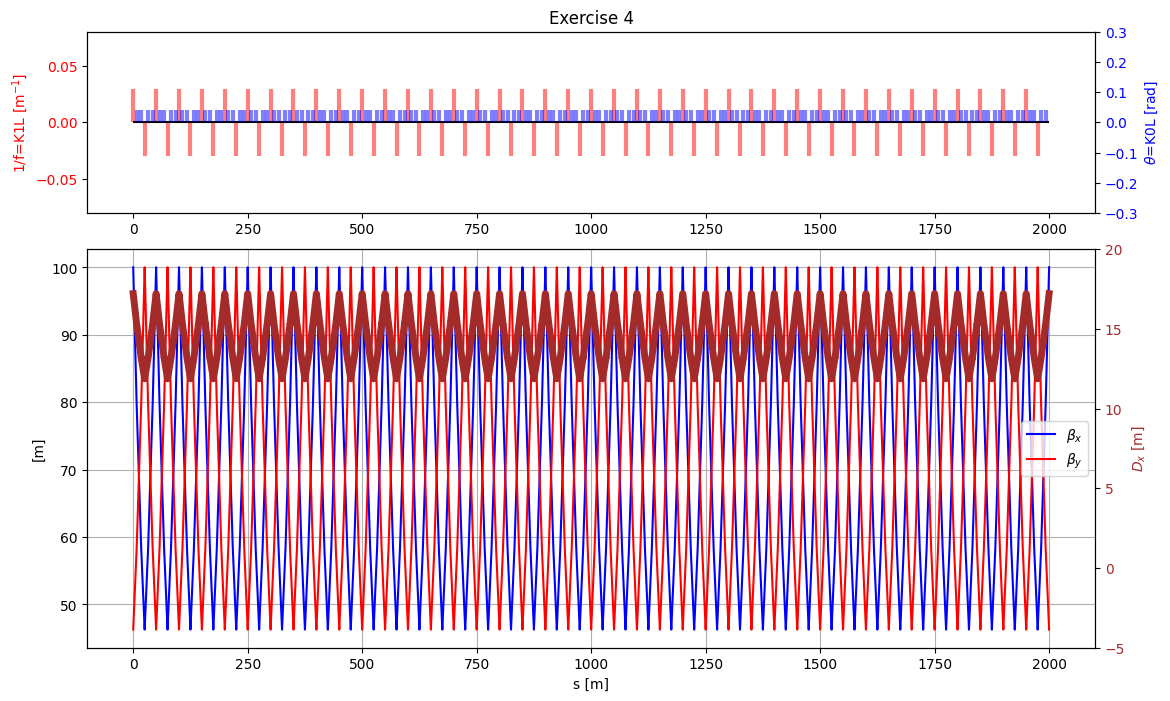

In [45]:
def plotLatticeSeries(ax,mys, length, height=1., v_offset=0., color='r',alpha=0.5,lw=3):

    ax.add_patch(
    patches.Rectangle(
        (mys, v_offset-height/2.),   # (x,y)
        length,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;

def useful_plots(transfer_line, tw1, ylim1=None, ylim2=None, ylim3=None, filter_elements="ThinSliceQuadrupole"):
    fig = plt.figure(figsize=(13,8))

    ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)

    #plt.grid()
    color = 'red'
    ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
    ax1.tick_params(axis='y', labelcolor=color)
    if ylim1 is not None:
        plt.ylim(ylim1[0], ylim1[1])
    else:
        plt.ylim(-.08,.08)
    #plt.ylim(-2,2)


    plt.title('Exercise 4')
    quads_table = transfer_line.get_table().rows[transfer_line.get_table().element_type ==  filter_elements] #
    for quad in quads_table.name:
        k1l = transfer_line.get_strengths().rows[quad].k1l[0] 
        aux = tw1.rows[quad].s[0]
        #print(quad, k1l) #transfer_line.get(quad)
        try:
            length = transfer_line.get(quad).length
        except:
            length=0
        plotLatticeSeries(plt.gca(),aux, length, height=k1l, v_offset=k1l/2, color='r')

    plt.hlines(y=0, xmin=0, xmax=circum,color="k")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'blue'
    ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)
    if ylim2 is not None:
        plt.ylim(ylim2[0], ylim2[1])
    else:
        plt.ylim(-.3,.3)
    #plt.ylim(-.3,.3)

    for quad in quads_table.name:
        k0l = transfer_line.get_strengths().rows[quad].k0l[0] 
        aux = tw1.rows[quad].s[0]
        #print(quad, k0l) #transfer_line.get(quad)
        try:
            length = transfer_line.get(quad).length
        except:
            length=0
        plotLatticeSeries(plt.gca(),aux, length, height=k0l, v_offset=k0l/2, color='b')

    ax3 = plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

    plt.plot(tw1['s'], tw1['betx'], label= r'$\beta_x$', c="blue")
    plt.plot(tw1['s'], tw1['bety'], label=r'$\beta_y$', c="red")
    plt.legend()
    plt.grid()
    plt.ylabel("[m]")
    plt.xlabel("s [m]")

    ax4 = plt.gca().twinx()
    plt.plot(tw1['s'], tw1["dx"], c="brown", lw=5)
    plt.ylabel(r"$D_x$ [m]", c="brown")
    plt.tick_params(axis='y', labelcolor='brown')
    if ylim3 is not None:
        plt.ylim(ylim3[0], ylim3[1])
    else:
        plt.ylim(-5, 20)
    return fig, ax1, ax2, ax3, ax4;

fig, ax1, ax2, ax3, ax4 = useful_plots(line, mytwiss, filter_elements="Multipole")

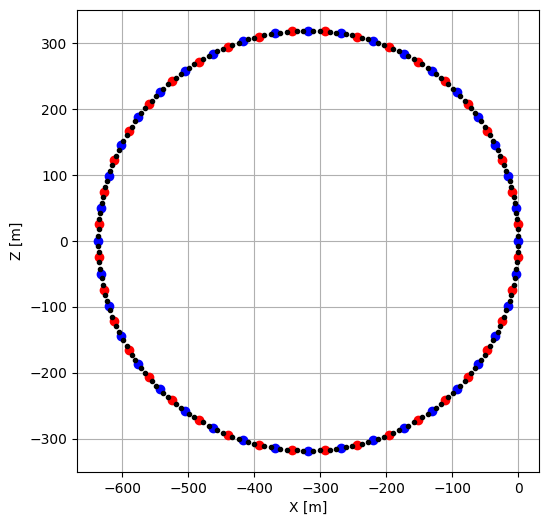

In [46]:
mySurvey = line.survey()
mySurvey = mySurvey.rows[r'^(mq|mb).*']

qfSurvey=mySurvey.rows[r'mqf.*']
qdSurvey=mySurvey.rows[r'mqd.*']
mbSurvey=mySurvey.rows[r'mb.*']



fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(qfSurvey.X,qfSurvey.Z,'ob')
plt.plot(qdSurvey.X,qdSurvey.Z,'or')
plt.plot(mbSurvey.X,mbSurvey.Z,'.k')
plt.axis('square')
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()

In [47]:
# %%
#### include dispersion suppressor and straight section


pc_GeV = 20.0

circum = 2000.0 # circumference
ncell = 40 # number of cells
lcell = circum/ncell # length of cell
lq=3.0 # length of quadrupole
#number_dipoles_percell = 4
nnorm=128.
theta = 2.0*np.pi/(nnorm) #(2.0*np.pi)/ncell/number_dipoles_percell
k1 = 0.0098 # quadrupole strength
lsex = 0.00001
ksf = +0.017041/ncell
ksd = -0.024714/ncell

env = xt.Environment()

env.vars({'lcell': lcell, 
          'lq': lq,
          'theta': theta,
          'kf': k1,
          'kd': -k1,
          'kfl': k1*lq,
          'kdl': -k1*lq,
          'lsex': lsex,
          'ksf': ksf,
            'ksd': ksd,
          })

#env.new('mb', xt.Bend, k0='theta', h='theta')
env.new('mb', xt.Multipole, knl=['theta', 0, 0], hxl='theta')
env.new('mqf', xt.Multipole, knl=[0, "kfl", 0])
env.new('mqd', xt.Multipole, knl=[0, "kdl", 0])
env.new("msf", xt.Multipole, knl=[0, 0, "ksf"])
env.new("msd", xt.Multipole, knl=[0, 0, "ksd"])

'msd'

In [48]:
cell = env.new_line(components=[
    env.new('cell_marker_start', xt.Marker, at=0),
    env.place('mqf', at=0),
    env.place('msf', at=lsex*0.5),
    env.place('mb', at=0.15*lcell),
    env.place('mb', at=0.35*lcell),
    env.place("mqd", at=0.5*lcell),
    env.place('msd', at=0.5*lcell + lsex*0.5),
    env.place('mb', at=0.65*lcell),
    env.place('mb', at=0.85*lcell),
    env.new('cell_marker_end', xt.Marker, at=lcell),
])


cell.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.000000,Marker,cell_marker_start,False,False,None,False,Marker(_dummy=0)
1,0.000000,Multipole,mqf,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
2,0.000000,Drift,drift_1,True,False,None,False,Drift(length=5e-06)
3,0.000005,Multipole,msf,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
4,0.000005,Drift,drift_2,True,False,None,False,Drift(length=7.5)
5,7.500000,Multipole,mb,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
6,7.500000,Drift,drift_3,True,False,None,False,Drift(length=10)
7,17.500000,Multipole,mb,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
8,17.500000,Drift,drift_4,True,False,None,False,Drift(length=7.5)
9,25.000000,Multipole,mqd,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."


In [49]:

#%%
dispersion_suppressor = env.new_line(components=[
    env.new('DS_marker_start', xt.Marker, at=0),
    env.place('mqf', at=0),
    env.place("mqd", at=0.5*lcell),
    env.place('mqf', at=1.0*lcell),
    env.place('mb', at=1.0*lcell + 0.15*lcell),
    env.place('mb', at=1.0*lcell + 0.35*lcell),
    env.place("mqd", at=lcell + 0.5*lcell),
    env.place('mb', at=1.0*lcell + 0.65*lcell),
    env.place('mb', at=1.0*lcell + 0.85*lcell),
    env.new('DS_marker_end', xt.Marker, at=2.0*lcell),
])

dispersion_suppressor.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Marker,DS_marker_start,False,False,None,False,Marker(_dummy=0)
1,0.0,Multipole,mqf,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
2,0.0,Drift,drift_9,True,False,None,False,Drift(length=25)
3,25.0,Multipole,mqd,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
4,25.0,Drift,drift_10,True,False,None,False,Drift(length=25)
5,50.0,Multipole,mqf,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
6,50.0,Drift,drift_11,True,False,None,False,Drift(length=7.5)
7,57.5,Multipole,mb,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
8,57.5,Drift,drift_12,True,False,None,False,Drift(length=10)
9,67.5,Multipole,mb,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."


In [50]:

#%%
# straight section
straight_section = env.new_line(components=[
    env.new('SS_marker_start', xt.Marker, at=0),
    env.place('mqf', at=0),
    env.place("mqd", at=0.5*lcell),
    env.place('mqf', at=1.0*lcell),
    env.place("mqd", at=1.0*lcell + 0.5*lcell),
    env.new('SS_marker_end', xt.Marker, at=2.0*lcell),
])

straight_section.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Marker,SS_marker_start,False,False,None,False,Marker(_dummy=0)
1,0.0,Multipole,mqf,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
2,0.0,Drift,drift_17,True,False,None,False,Drift(length=25)
3,25.0,Multipole,mqd,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
4,25.0,Drift,drift_18,True,False,None,False,Drift(length=25)
5,50.0,Multipole,mqf,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
6,50.0,Drift,drift_19,True,False,None,False,Drift(length=25)
7,75.0,Multipole,mqd,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
8,75.0,Drift,drift_20,True,False,None,False,Drift(length=25)
9,100.0,Marker,SS_marker_end,False,False,None,False,Marker(_dummy=0)


In [51]:

#%%

# dispersion suppressor reversed

dispersion_suppressor2 = env.new_line(components=[
    env.new('DS2_marker_start', xt.Marker, at=0),
    env.place('mqf', at=0),
    env.place('mb', at=0.15*lcell),
    env.place('mb', at=0.35*lcell),
    env.place("mqd", at=0.5*lcell),
    env.place('mb', at= 0.65*lcell),
    env.place('mb', at=0.85*lcell),
    env.place('mqf', at=1.0*lcell),
    env.place("mqd", at=1.0*lcell + 0.5*lcell),
    env.new('DS2_marker_end', xt.Marker, at=2.0*lcell),
])

dispersion_suppressor2.to_pandas()

#%%

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Marker,DS2_marker_start,False,False,None,False,Marker(_dummy=0)
1,0.0,Multipole,mqf,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
2,0.0,Drift,drift_21,True,False,None,False,Drift(length=7.5)
3,7.5,Multipole,mb,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
4,7.5,Drift,drift_22,True,False,None,False,Drift(length=10)
5,17.5,Multipole,mb,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
6,17.5,Drift,drift_23,True,False,None,False,Drift(length=7.5)
7,25.0,Multipole,mqd,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
8,25.0,Drift,drift_24,True,False,None,False,Drift(length=7.5)
9,32.5,Multipole,mb,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."


In [52]:

#%% append in cells number_of_FODO times cell
line = env.new_line(components=
                    
                    [env.place(cell)]*4
                    + [env.place(dispersion_suppressor)]*1
                    + [env.new('SS_marker_start_first', xt.Marker)]
                    + [env.place(straight_section)]*1
                    + [env.place(dispersion_suppressor2)]*1
                    + [env.place(cell)]*14
                    + [env.place(dispersion_suppressor)]*1
                    + [env.place(straight_section)]*1
                    + [env.place(dispersion_suppressor2)]*1
                    + [env.place(cell)]*10
                    
                    )

line.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.000000,Marker,cell_marker_start,False,False,None,False,Marker(_dummy=0)
1,0.000000,Multipole,mqf,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
2,0.000000,Drift,drift_1,True,False,None,False,Drift(length=5e-06)
3,0.000005,Multipole,msf,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
4,0.000005,Drift,drift_2,True,False,None,False,Drift(length=7.5)
...,...,...,...,...,...,...,...,...
593,1982.500000,Drift,drift_7,True,False,None,False,Drift(length=10)
594,1992.500000,Multipole,mb,False,False,None,False,"Multipole(_order=2, inv_factorial_order=0.5, l..."
595,1992.500000,Drift,drift_8,True,False,None,False,Drift(length=7.5)
596,2000.000000,Marker,cell_marker_end,False,False,None,False,Marker(_dummy=0)


In [53]:

# %%

line.particle_ref = xt.Particles(p0c=pc_GeV*1e9, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)
context = xo.ContextCpu()
line.build_tracker(_context=context)
#line.twiss(method="4d")

#mytwiss = line.twiss(method="4d")
#fig, ax1, ax2, ax3, ax4 = useful_plots(line, mytwiss, filter_elements="Multipole")


Before match:el call n. 0               
Target status:                          
id state tag  tol_met       residue   current_val    target_val description                            
0  ON    tune   False      -1.87522       4.79145       6.66667 'qx', val=6.66667, tol=1e-06, weight=10
1  ON    tune   False      -1.87522       4.79145       6.66667 'qy', val=6.66667, tol=1e-06, weight=10
Matching: model call n. 13               

After match:
Target status:                           
id state tag  tol_met       residue   current_val    target_val description                            
0  ON    tune    True  -1.46682e-08       6.66667       6.66667 'qx', val=6.66667, tol=1e-06, weight=10
1  ON    tune    True   1.80356e-08       6.66667       6.66667 'qy', val=6.66667, tol=1e-06, weight=10

Match history
{'kfl': 0.0294, 'kdl': -0.0294}


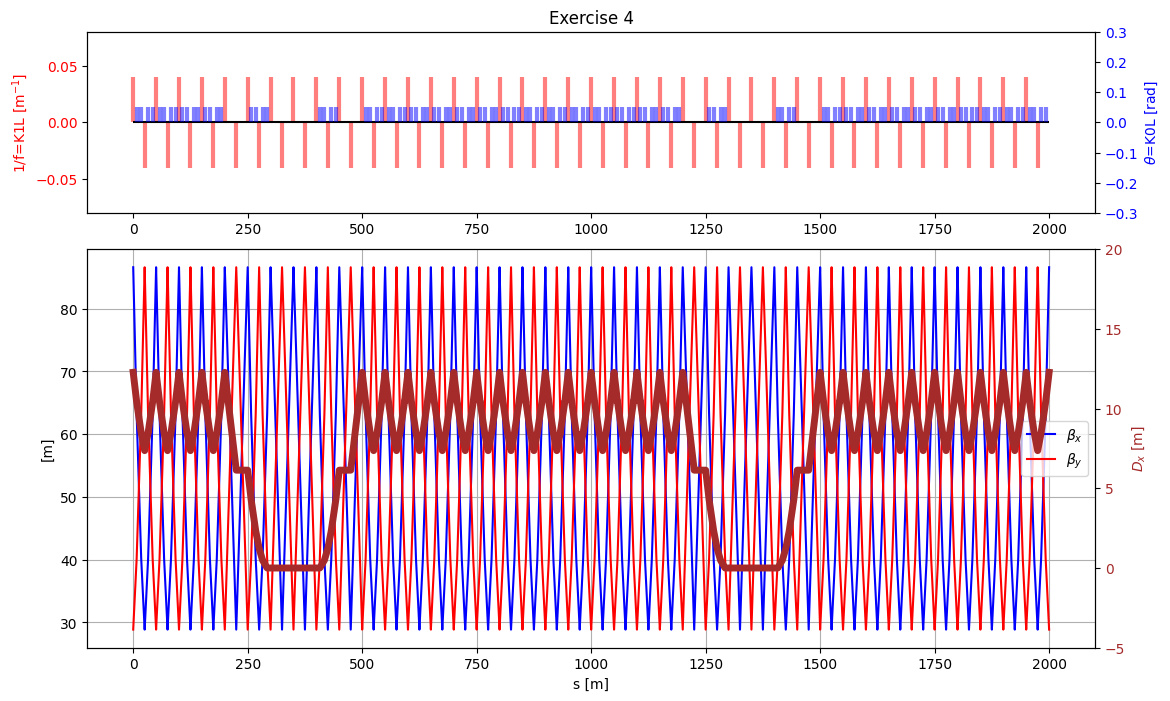

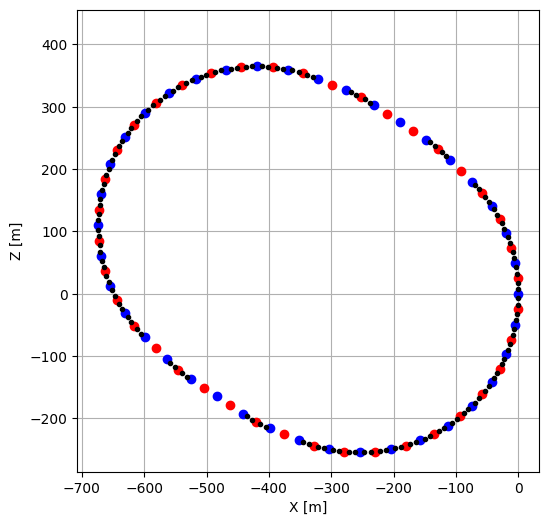

In [54]:


#%%
opt = line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['kfl', 'kdl'], step=1e-5),
    targets=xt.TargetSet(qx=ncell/6., qy=ncell/6., tol=1e-6, tag='tune'
    ))
#%%
print('Before match:')
opt.target_status()

opt.solve()

print('After match:')
opt.target_status()

print('\nMatch history')
opt.log()

# %%
knobs_after_match = opt.get_knob_values()
knobs_before_match = opt.get_knob_values(iteration=0)
print(knobs_before_match)


#%%
mytwiss = line.twiss(method="4d")
fig, ax1, ax2, ax3, ax4 = useful_plots(line, mytwiss, filter_elements="Multipole")
# %%
mySurvey = line.survey()
mySurvey = mySurvey.rows[r'^(mq|mb).*']

qfSurvey=mySurvey.rows[r'mqf.*']
qdSurvey=mySurvey.rows[r'mqd.*']
mbSurvey=mySurvey.rows[r'mb.*']



fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(qfSurvey.X,qfSurvey.Z,'ob')
plt.plot(qdSurvey.X,qdSurvey.Z,'or')
plt.plot(mbSurvey.X,mbSurvey.Z,'.k')
plt.axis('square')
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()


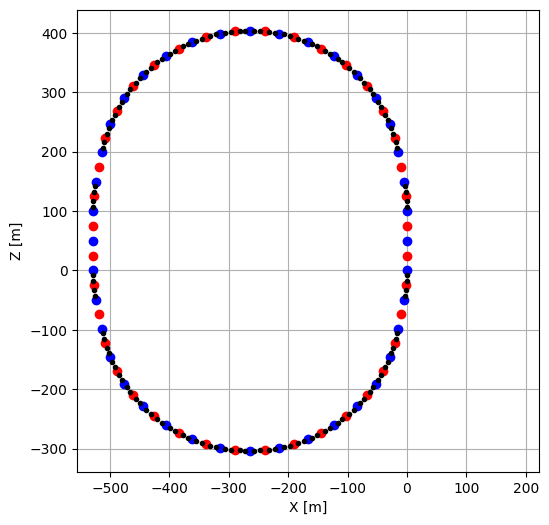

In [55]:
# %%
line_cycled = line.cycle("SS_marker_start_first")
# %%
mySurvey = line_cycled.survey()
mySurvey = mySurvey.rows[r'^(mq|mb).*']

qfSurvey=mySurvey.rows[r'mqf.*']
qdSurvey=mySurvey.rows[r'mqd.*']
mbSurvey=mySurvey.rows[r'mb.*']

fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(qfSurvey.X,qfSurvey.Z,'ob')
plt.plot(qdSurvey.X,qdSurvey.Z,'or')
plt.plot(mbSurvey.X,mbSurvey.Z,'.k')
plt.axis('square')
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()
# %%

# Half dipole approach

Before match:el call n. 0               
Target status:                          
id state tag  tol_met       residue   current_val    target_val description                         
0  ON    tune   False      -1.90855       4.79145           6.7 'qx', val=6.7, tol=1e-06, weight=10 
1  ON    tune   False      -1.85855       4.79145          6.65 'qy', val=6.65, tol=1e-06, weight=10
Matching: model call n. 13               

After match:
Target status:                           
id state tag  tol_met       residue   current_val    target_val description                         
0  ON    tune    True  -1.82485e-08           6.7           6.7 'qx', val=6.7, tol=1e-06, weight=10 
1  ON    tune    True    1.5198e-08          6.65          6.65 'qy', val=6.65, tol=1e-06, weight=10

Match history
{'kfl': 0.0294, 'kdl': -0.0294}


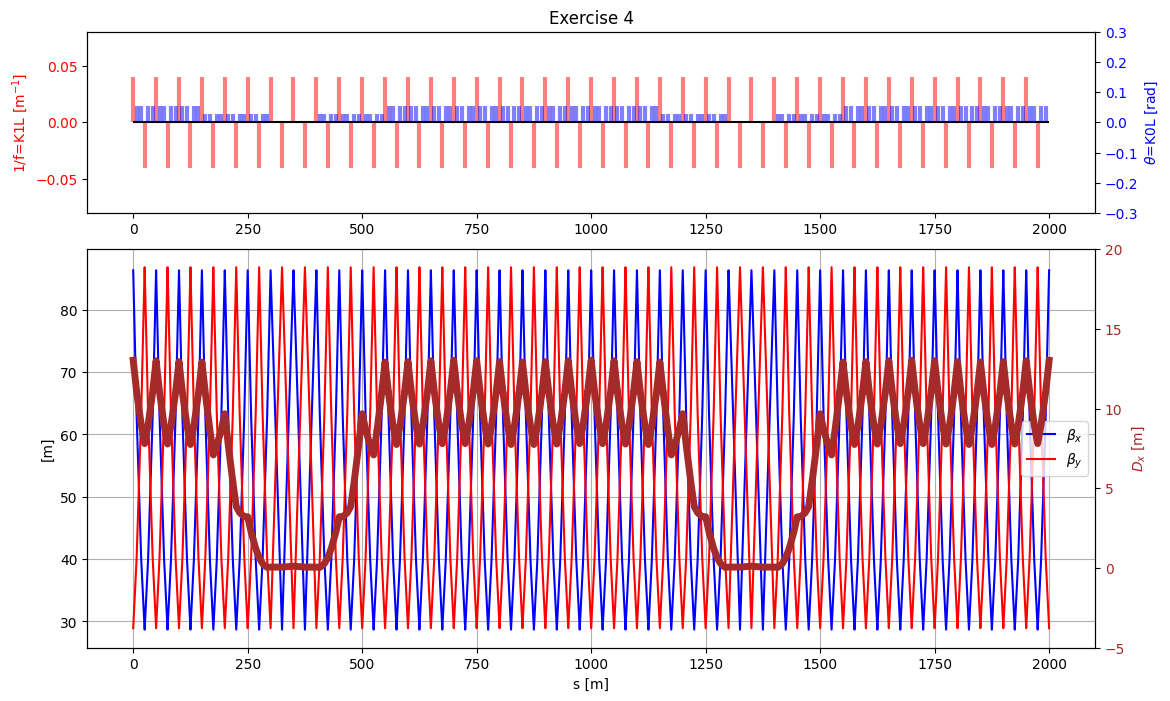

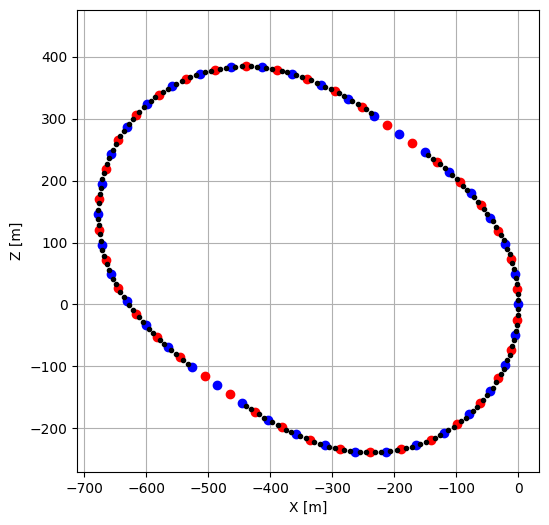

In [57]:






pc_GeV = 20.0

circum = 2000.0 # circumference
ncell = 40 # number of cells
lcell = circum/ncell # length of cell
lq=3.0 # length of quadrupole
#number_dipoles_percell = 4
nnorm=120.0
theta = 2.0*np.pi/(nnorm)
theta2 = 1.0*np.pi/(nnorm)  #(2.0*np.pi)/ncell/number_dipoles_percell
k1 = 0.0098 # quadrupole strength
lsex = 0.00001
ksf = +0.017041/20.0
ksd = -0.024714/20.0

env = xt.Environment()

env.vars({'lcell': lcell, 
          'lq': lq,
          'theta': theta,
          'theta2': theta2,
          'kf': k1,
          'kd': -k1,
          'kfl': k1*lq,
          'kdl': -k1*lq,
          'lsex': lsex,
          'ksf': ksf,
            'ksd': ksd,
          })

#env.new('mb', xt.Bend, k0='theta', h='theta')
env.new('mb', xt.Multipole, knl=['theta', 0, 0], hxl='theta')
env.new('mb2', xt.Multipole, knl=['theta2', 0, 0], hxl='theta2')
env.new('mqf', xt.Multipole, knl=[0, "kfl", 0])
env.new('mqd', xt.Multipole, knl=[0, "kdl", 0])
env.new("msf", xt.Multipole, knl=[0, 0, "ksf"])
env.new("msd", xt.Multipole, knl=[0, 0, "ksd"])


cell = env.new_line(components=[
    env.new('cell_marker_start', xt.Marker, at=0),
    env.place('mqf', at=0),
    env.place('msf', at=lsex*0.5),
    env.place('mb', at=0.15*lcell),
    env.place('mb', at=0.35*lcell),
    env.place("mqd", at=0.5*lcell),
    env.place('msd', at=0.5*lcell + lsex*0.5),
    env.place('mb', at=0.65*lcell),
    env.place('mb', at=0.85*lcell),
    env.new('cell_marker_end', xt.Marker, at=lcell),
])


cell.to_pandas()

#%%
dispersion_suppressor = env.new_line(components=[
    env.new('DS_marker_start', xt.Marker, at=0),
    env.place('mqf', at=0),
    env.place('mb2', at=0.15*lcell),
    env.place('mb2', at=0.35*lcell),
    env.place("mqd", at= 0.5*lcell),
    env.place('mb2', at= 0.65*lcell),
    env.place('mb2', at=0.85*lcell),
    env.new('DS_marker_end', xt.Marker, at=1.0*lcell),
])

dispersion_suppressor.to_pandas()



#%%
# straight section
straight_section = env.new_line(components=[
    env.new('SS_marker_start', xt.Marker, at=0),
    env.place('mqf', at=0),
    env.place("mqd", at=0.5*lcell),
    env.place('mqf', at=1.0*lcell),
    env.place("mqd", at=1.0*lcell + 0.5*lcell),
    env.new('SS_marker_end', xt.Marker, at=2.0*lcell),
])

straight_section.to_pandas()

#%%

# dispersion suppressor reversed

dispersion_suppressor2 = env.new_line(components=[
    env.new('DS2_marker_start', xt.Marker, at=0),
    env.place('mqf', at=0),
    env.place('mb2', at=0.15*lcell),
    env.place('mb2', at=0.35*lcell),
    env.place("mqd", at=0.5*lcell),
    env.place('mb2', at= 0.65*lcell),
    env.place('mb2', at=0.85*lcell),
    env.new('DS2_marker_end', xt.Marker, at=1.0*lcell),
])

dispersion_suppressor2.to_pandas()

#%%


#%% append in cells number_of_FODO times cell
line = env.new_line(components=
                    
                    [env.place(cell)]*3
                    + [env.place(dispersion_suppressor)]*3
                    + [env.new('SS_marker_start_first', xt.Marker)]
                    + [env.place(straight_section)]*1
                    + [env.place(dispersion_suppressor2)]*3
                    + [env.place(cell)]*12
                    + [env.place(dispersion_suppressor)]*3
                    + [env.place(straight_section)]*1
                    + [env.place(dispersion_suppressor2)]*3
                    + [env.place(cell)]*9
                    
                    )

line.to_pandas()
# %%

line.particle_ref = xt.Particles(p0c=pc_GeV*1e9, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)
context = xo.ContextCpu()
line.build_tracker(_context=context)
line.twiss(method="4d")

#mytwiss = line.twiss(method="4d")
#fig, ax1, ax2, ax3, ax4 = useful_plots(line, mytwiss, filter_elements="Multipole")

#%%
opt = line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['kfl', 'kdl'], step=1e-5),
    targets=xt.TargetSet(qx=6.7, qy=6.65, tol=1e-6, tag='tune'
    ))
#%%
print('Before match:')
opt.target_status()

opt.solve()

print('After match:')
opt.target_status()

print('\nMatch history')
opt.log()

# %%
knobs_after_match = opt.get_knob_values()
knobs_before_match = opt.get_knob_values(iteration=0)
print(knobs_before_match)


#%%
mytwiss = line.twiss(method="4d")
fig, ax1, ax2, ax3, ax4 = useful_plots(line, mytwiss, filter_elements="Multipole")

# %%
mySurvey = line.survey()
mySurvey = mySurvey.rows[r'^(mq|mb).*']

qfSurvey=mySurvey.rows[r'mqf.*']
qdSurvey=mySurvey.rows[r'mqd.*']
mbSurvey=mySurvey.rows[r'mb.*']



fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(qfSurvey.X,qfSurvey.Z,'ob')
plt.plot(qdSurvey.X,qdSurvey.Z,'or')
plt.plot(mbSurvey.X,mbSurvey.Z,'.k')
plt.axis('square')
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()
# %%
